In [1]:
import torch
import os
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

os.chdir('/Users/lucreziavaleriani/Documents/GitHub/LOCATE/')

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
data = '/Users/lucreziavaleriani/Desktop/orfeo_LTS/CNA/segmentation/sim_data_races/data_races/'
sim = 'sim_12'
comb = [c for c in os.listdir(f'{data}{sim}') if c.startswith('cov')]
print(comb)
c = comb[-8]
print(c)

data = pd.read_csv(f'{data}{sim}/{c}/mirr_smooth_snv.csv').sort_values('pos')

data_input = {'baf':torch.tensor(np.array(data['mean_baf']).reshape(-1, 1)), 
              'dr':torch.tensor(np.array(data['mean_dr']).reshape(-1, 1)),
              'vaf':torch.tensor(np.array(data['NV']).reshape(-1, 1)),
              'dp':torch.tensor(np.array(data['DP']).reshape(-1, 1)),
              'dp_snp':torch.tensor(np.array(data['mean_dp']).reshape(-1, 1))}

['cov_30_p_0.9', 'cov_30_p_0.6', 'cov_30_p_0.3', 'cov_50_p_0.9', 'cov_50_p_0.6', 'cov_50_p_0.3', 'cov_70_p_0.9', 'cov_70_p_0.6', 'cov_70_p_0.3', 'cov_100_p_0.9', 'cov_100_p_0.6', 'cov_100_p_0.3']
cov_50_p_0.6


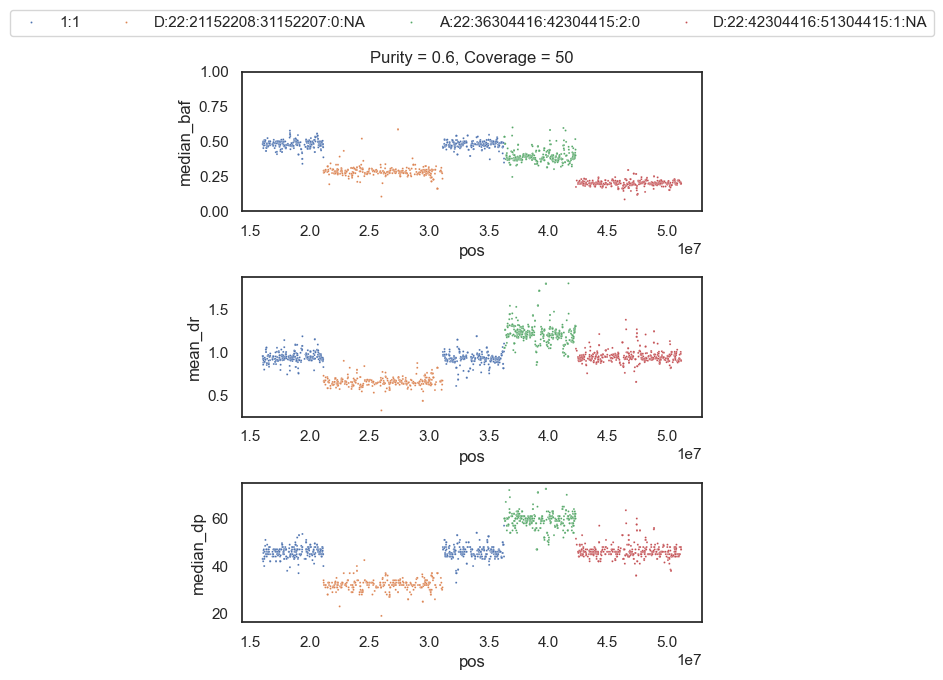

In [42]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(3, 1, figsize=(8, 7))

baf = sns.scatterplot(data=data, x="pos", y="median_baf", s=2, ax=axes[0], hue="cna_id")
dr = sns.scatterplot(data=data, x="pos", y="mean_dr", s=2, ax=axes[1], hue="cna_id", legend=False)
dp = sns.scatterplot(data=data, x="pos", y="median_dp", s=2, ax=axes[2], hue="cna_id", legend=False)

axes[0].set_ylim(0,1) 
sns.move_legend(
    baf, 
    "lower center",
    bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=True,
)

purity = c.split('_')[-1]
coverage = c.split('_')[1]
axes[0].set_title(f'Purity = {purity}, Coverage = {coverage}')
fig.tight_layout()

In [43]:
import locate as l
from locate.models import Clonal
from locate.utils import plot_loss

In [44]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"], 
                         "dr": data_input["dr"], 
                         "vaf": None,
                         "dp": None,
                         #"vaf": data_input["vaf"], 
                         "dp_snp": data_input["dp_snp"], 
                         #"dp": data_input["dp"]
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "prior_purity": float(purity),
                         "prior_ploidy": 2})

In [45]:
ll = locate.run(steps = 700, param_optimizer = {"lr" : 0.05})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: -3208.502968072  : 100%|██████████| 700/700 [00:06<00:00, 103.24it/s]


Done!


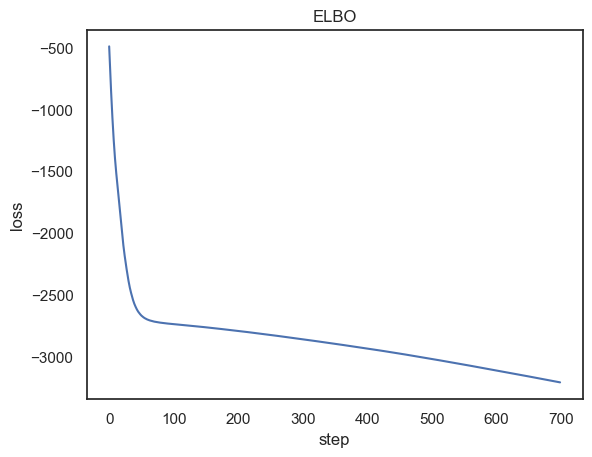

In [46]:
plot_loss(ll[0])

In [47]:
bau = locate.learned_parameters()
print(bau)

torch.Size([5, 1])
tensor([[18.9889],
        [12.2924],
        [45.2000],
        [28.7462],
        [45.2000]], dtype=torch.float64, grad_fn=<DivBackward0>)
torch.Size([5, 1]) alhpa
torch.Size([5, 1, 1])
tensor([[[18.9889]],

        [[12.2924]],

        [[45.2000]],

        [[28.7462]],

        [[45.2000]]], dtype=torch.float64, grad_fn=<DivBackward0>)
torch.Size([5, 1, 1]) alhpa
torch.Size([5, 1])
tensor([[18.9889],
        [12.2924],
        [45.2000],
        [28.7462],
        [45.2000]], dtype=torch.float64, grad_fn=<DivBackward0>)
torch.Size([5, 1]) alhpa
torch.Size([5, 1, 1])
tensor([[[19.4977]],

        [[12.6118]],

        [[46.4500]],

        [[29.5309]],

        [[46.4500]]], dtype=torch.float64, grad_fn=<DivBackward0>)
torch.Size([5, 1, 1]) alhpa
torch.Size([5, 1])
tensor([[19.4773],
        [12.5990],
        [46.4000],
        [29.4995],
        [46.4000]], dtype=torch.float64, grad_fn=<DivBackward0>)
torch.Size([5, 1]) alhpa
torch.Size([5, 1, 1])
tensor([[[19.

In [48]:
res = pd.DataFrame({'CN_Major':bau["CN_Major"]+0.05,
                    'CN_minor':bau["CN_minor"]-0.05,
                    'pos':[i for i in range(len(bau["CN_minor"]))]})



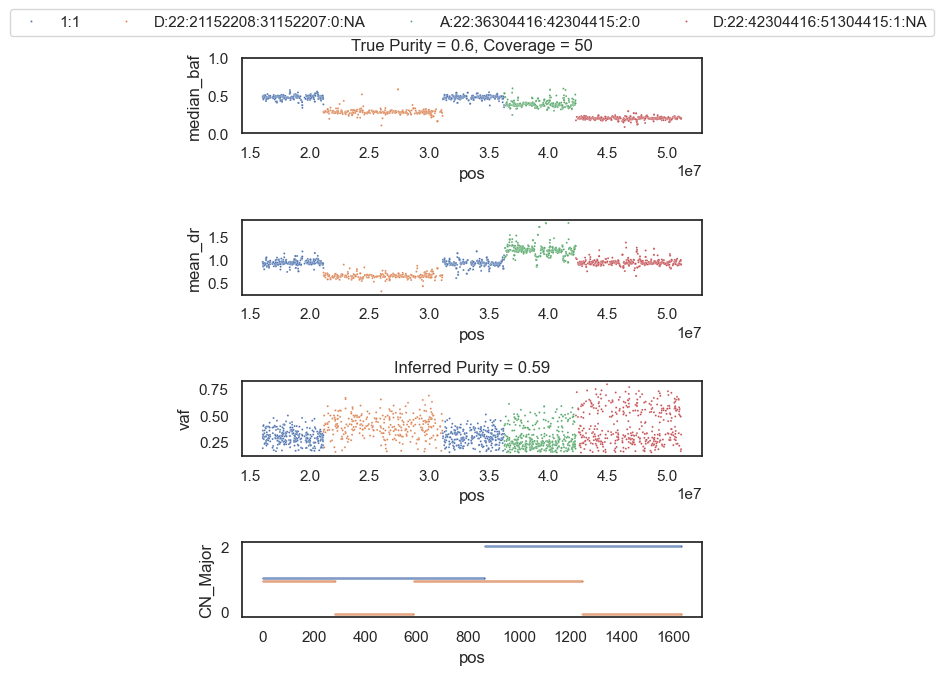

In [49]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(8, 7))

baf = sns.scatterplot(data=data, x="pos", y="median_baf", s=2, ax=axes[0], hue="cna_id")
dr = sns.scatterplot(data=data, x="pos", y="mean_dr", s=2, ax=axes[1], hue="cna_id", legend=False)
vaf = sns.scatterplot(data=data, x="pos", y="vaf", s=2, ax=axes[2], hue="cna_id", legend=False)

cn = sns.scatterplot(data=res, x="pos", y="CN_Major", s=2, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res, x="pos", y="CN_minor", s=2, ax=axes[3], legend=False)

axes[0].set_ylim(0,1) 
sns.move_legend(
    baf, 
    "lower center",
    bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=True,
)

axes[0].set_title(f'True Purity = {purity}, Coverage = {coverage}')
inf_purity = float(bau['purity'])
axes[2].set_title(f'Inferred Purity = {round(inf_purity, 2)}')
fig.tight_layout()